In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [2]:
# FILTROS BASE DE DATOS
TABLE_TYPE = 'domestic'  # 'domestic' o 'european'
LEAGUES = [      # Lista de ligas a incluir
    'ESP-La Liga'
]
SEASON = '2425'       # Temporada específica (ej: '2425', '2324')
POSITION_FILTER = 'MF'   # 'GK', 'DF', 'MF', 'FW' - primera posición (ej: 'MF')
MIN_MINUTES = 800        # Minutos mínimos (ej: 800)

# JUGADORES A ANALIZAR
PLAYER_1_SEARCH = 'Pedri'      # Nombre jugador 1 (ej: 'Pedri')
PLAYER_2_SEARCH = 'Bellingham' # Nombre jugador 2 (ej: 'Bellingham')

# CONFIGURACIÓN RADAR
RADAR_TITLE = "El Clásico Midfield"              # Título (ej: "Centre Mid Template")
RADAR_DESCRIPTION = "Pedri vs Bellingham - La Liga 24/25 (800+ mins)"        # Descripción (ej: "vs Top-5 League MF (800+ mins) 2024/25")
TEAM_COLORS = ['#004D98', '#FFFFFF']      # Colores (ej: ['#004D98', '#FFFFFF'])
SAVE_PATH_BASE = "images/pedri_bellingham_laliga"    # Ruta base (ej: "images/comparison")

print(f"Config: {len(LEAGUES)} ligas, temporada {SEASON}, pos '{POSITION_FILTER}', min {MIN_MINUTES} min")

Config: 1 ligas, temporada 2425, pos 'MF', min 800 min


In [3]:
# Conexión BD
db = get_db_manager()

# Query dinámico
table_suffix = TABLE_TYPE
league_list_str = "', '".join(LEAGUES)

# Construir columnas según tipo de tabla
if TABLE_TYPE == 'domestic':
    metrics_cols = "fbref_metrics, understat_metrics"
    league_col = "league"
else:
    metrics_cols = "fbref_metrics"
    league_col = "competition"

query_template = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    {league_col},
    season,
    position,
    nationality,
    age,
    {metrics_cols}
FROM footballdecoded.players_{table_suffix} p
WHERE p.{league_col} IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.{league_col}, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query_template, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

Extraídos: 588 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,db4452eac2b4de06,Abdel Abqar,Alavés,ESP-La Liga,2425,DF,MAR,25.0,"{'FK': '0', 'OG': '0', 'Crs': '5', 'Fld': '31'...","{'understat_xa': '0.23812325112521648', 'under..."
1,8820f1f696b5126b,Abderrahman Rebbach,Alavés,ESP-La Liga,2425,"FW,MF",ALG,25.0,"{'FK': '0', 'OG': '0', 'Crs': '17', 'Fld': '6'...","{'understat_xa': '0.27545187063515186', 'under..."
2,a3463ccf35649c59,Adrian Rodriguez,Alavés,ESP-La Liga,2425,GK,ESP,23.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.3...","{'understat_xa': '0.35549480095505714', 'under..."
3,c16ef47f7c6492a7,Aleksandar Sedlar,Alavés,ESP-La Liga,2425,DF,SRB,32.0,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '5',...","{'understat_xa': '0.0', 'understat_team': 'Ala..."
4,a9c5ac8ef2ca1ac3,Ander Guevara,Alavés,ESP-La Liga,2425,MF,ESP,27.0,"{'FK': '0', 'OG': '0', 'Crs': '5', 'Fld': '18'...","{'understat_xa': '0.6741306530311704', 'unders..."


In [4]:
# Verificar posiciones disponibles
positions = df_raw['position'].value_counts().sort_index()
print(f"Posiciones: {sorted(df_raw['position'].unique())}")

# Filtrar por posición
if POSITION_FILTER:
    df_position = df_raw[df_raw['position'].str.startswith(POSITION_FILTER)].copy()
    print(f"Filtrado '{POSITION_FILTER}': {df_position.shape[0]} jugadores")
else:
    df_position = df_raw.copy()
    print(f"Sin filtro posición: {df_position.shape[0]} jugadores")

Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Filtrado 'MF': 197 jugadores


In [5]:
# Filtrar por minutos mínimos
df_filtered = df_position[
    df_position['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min: {df_filtered.shape[0]} jugadores")
df_filtered.head()

Filtro 800+ min: 120 jugadores


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
4,a9c5ac8ef2ca1ac3,Ander Guevara,Alavés,ESP-La Liga,2425,MF,ESP,27.0,"{'FK': '0', 'OG': '0', 'Crs': '5', 'Fld': '18'...","{'understat_xa': '0.6741306530311704', 'unders..."
5,99eb84d358ed0cf1,Antonio Blanco,Alavés,ESP-La Liga,2425,MF,ESP,24.0,"{'CS': '8', 'FK': '0', 'OG': '0', '/90': '0.06...","{'understat_xa': '1.7390412520617247', 'unders..."
8,e3ac395056a774aa,Carles Aleñá,Alavés,ESP-La Liga,2425,"MF,FW",ESP,26.0,"{'FK': '1', 'OG': '0', 'Crs': '31', 'Fld': '24...","{'understat_xa': '2.068190712481737', 'underst..."
15,08715d0d9698438f,Joan Jordán,Alavés,ESP-La Liga,2425,MF,ESP,30.0,"{'CS': '8', 'FK': '5', 'OG': '0', '/90': '0.2'...","{'understat_xa': '2.1695005875080824', 'unders..."
16,eb997f1d03e675ca,Jon Guridi,Alavés,ESP-La Liga,2425,"MF,FW",ESP,29.0,"{'FK': '0', 'OG': '0', 'Crs': '17', 'Fld': '14...","{'understat_xa': '1.142053421586752', 'underst..."


In [6]:
# Extraer métricas disponibles
fbref_metrics_all = set()
understat_metrics_all = set()

for _, row in df_filtered.iterrows():
    if row['fbref_metrics']:
        fbref_metrics_all.update(row['fbref_metrics'].keys())
    if TABLE_TYPE == 'domestic' and row['understat_metrics']:
        understat_metrics_all.update(row['understat_metrics'].keys())

print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_metrics_all))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

if TABLE_TYPE == 'domestic':
    print("\n\nMÉTRICAS UNDERSTAT DISPONIBLES:")
    print("=" * 50)
    understat_sorted = sorted(list(understat_metrics_all))
    for i, metric in enumerate(understat_sorted, 1):
        print(f"{i:2d}. {metric}")
    
    print(f"\nTotal Understat: {len(understat_sorted)}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [7]:
def extract_metrics(df, col_name):
    """Extrae métricas numéricas de diccionarios"""
    result = pd.DataFrame(index=df.index)
    
    # Obtener keys únicas
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    # Extraer cada métrica
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        # Solo incluir métricas con 5+ valores válidos
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    """Convierte valor a float de manera robusta"""
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
if TABLE_TYPE == 'domestic':
    understat_nums = extract_metrics(df_filtered, 'understat_metrics')
    print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")
else:
    understat_nums = pd.DataFrame(index=df_filtered.index)
    print(f"FBref: {fbref_nums.shape[1]} métricas extraídas")

FBref: 185 métricas | Understat: 10 métricas


In [8]:
# Calcular percentiles (1-99)
fbref_pct = fbref_nums.rank(pct=True) * 98 + 1
fbref_pct = fbref_pct.round(0).astype('Int64')
fbref_pct.columns = [f'{col}_pct' for col in fbref_pct.columns]

if TABLE_TYPE == 'domestic':
    understat_pct = understat_nums.rank(pct=True) * 98 + 1
    understat_pct = understat_pct.round(0).astype('Int64')
    understat_pct.columns = [f'{col}_pct' for col in understat_pct.columns]
    print(f"Percentiles: {fbref_pct.shape[1]} + {understat_pct.shape[1]}")
else:
    understat_pct = pd.DataFrame(index=df_filtered.index)
    print(f"Percentiles: {fbref_pct.shape[1]}")

Percentiles: 185 + 10


In [9]:
# Métricas a excluir de per90 (ya normalizadas o ratios)
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
if TABLE_TYPE == 'domestic':
    understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
    understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
    understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]
    print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")
else:
    understat_per90 = pd.DataFrame(index=df_filtered.index)
    print(f"Per90: {fbref_per90.shape[1]}")

Per90: 154 + 7


In [10]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']
if TABLE_TYPE == 'european':
    base_cols = ['unique_player_id', 'player_name', 'team', 'competition', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    fbref_nums,           # Métricas originales FBref
    understat_nums,       # Métricas originales Understat
    fbref_pct,           # Percentiles FBref
    understat_pct,       # Percentiles Understat
    fbref_per90,         # Per90 FBref
    understat_per90      # Per90 Understat
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

DataFrame final: 120 filas, 557 columnas


In [11]:
def clean_series_values(df):
    """Limpia Series anidados en DataFrame"""
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas conocidas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada: 555 columnas finales


In [12]:
# Buscar jugadores configurados
if PLAYER_1_SEARCH:
    search1 = df_filtered[df_filtered['player_name'].str.contains(PLAYER_1_SEARCH, case=False, na=False)]
    print(f"Búsqueda '{PLAYER_1_SEARCH}':")
    for _, player in search1.iterrows():
        print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league' if TABLE_TYPE == 'domestic' else 'competition']})")

if PLAYER_2_SEARCH:
    search2 = df_filtered[df_filtered['player_name'].str.contains(PLAYER_2_SEARCH, case=False, na=False)]
    print(f"\nBúsqueda '{PLAYER_2_SEARCH}':")
    for _, player in search2.iterrows():
        print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league' if TABLE_TYPE == 'domestic' else 'competition']})")

Búsqueda 'Pedri':
  8c50fb1a1662d90f - Pedri (Barcelona, ESP-La Liga)

Búsqueda 'Bellingham':
  1b18fe1684f965aa - Jude Bellingham (Real Madrid, ESP-La Liga)


In [13]:
PLAYER_1_ID = "8c50fb1a1662d90f"  # Copiar unique_player_id de búsqueda anterior
PLAYER_2_ID = "1b18fe1684f965aa"  # Copiar unique_player_id de búsqueda anterior (opcional)

In [14]:
# MÉTRICAS DEL RADAR - CONFIGURAR AQUÍ (exactamente 10 métricas)
radar_metrics = [
    'goals_per90', 'assists_per90',
    'expected_assists_per90', 'understat_npxg_plus_xa_per90', 'progressive_passes_per90',
    'key_passes_per90', 'passes_final_third_per90', 'pass_completion_pct',
    'tackles_won_per90', 'interceptions_per90'
]

radar_titles = [
    'Goals\nper 90', 'Assists\nper 90',
    'Expected\nAssists per 90', 'npxG + xA\nper 90', 'Progressive\nPasses per 90',
    'Key Passes\nper 90', 'Passes Final\nThird per 90', 'Pass Accuracy\n%',
    'Tackles Won\nper 90', 'Interceptions\nper 90'
]

# Verificar que hay exactamente 10 métricas
if len(radar_metrics) != 10 or len(radar_titles) != 10:
    print(f"ERROR: Se requieren exactamente 10 métricas y títulos")
    print(f"Actual: {len(radar_metrics)} métricas, {len(radar_titles)} títulos")
else:
    print(f"Métricas radar configuradas: {len(radar_metrics)} métricas")

# LOGOS DE EQUIPOS (opcional)
team_logos = {
    'Barcelona': '../logos/LaLiga/FC Barcelona.png',
    'Real Madrid': '../logos/LaLiga/Real Madrid.png'
}

Métricas radar configuradas: 10 métricas


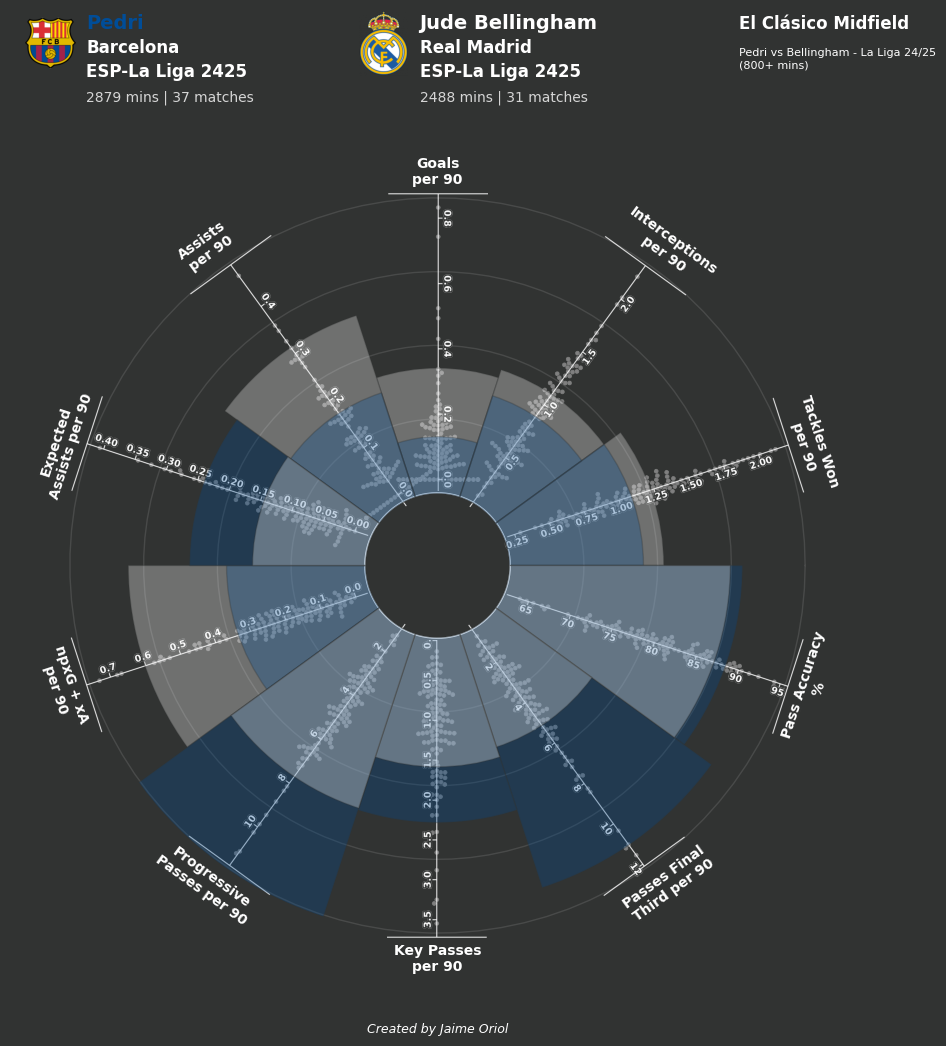

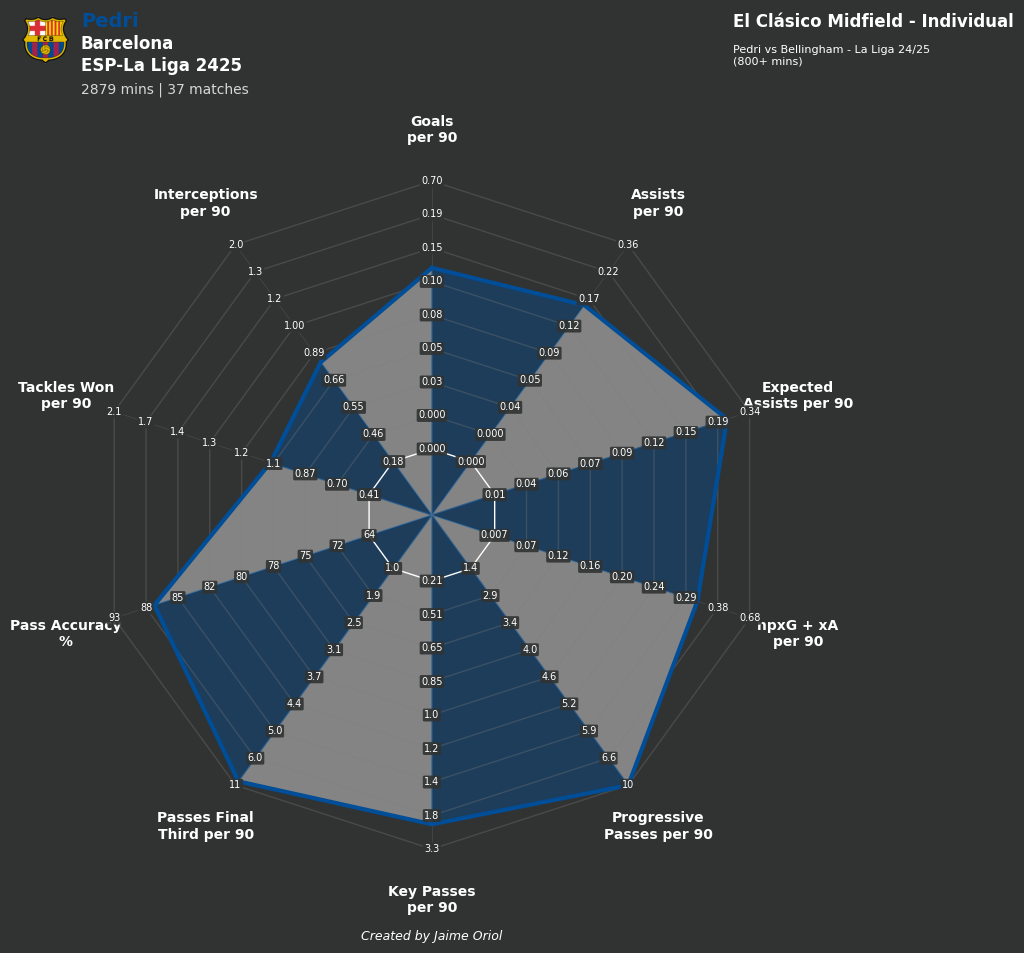

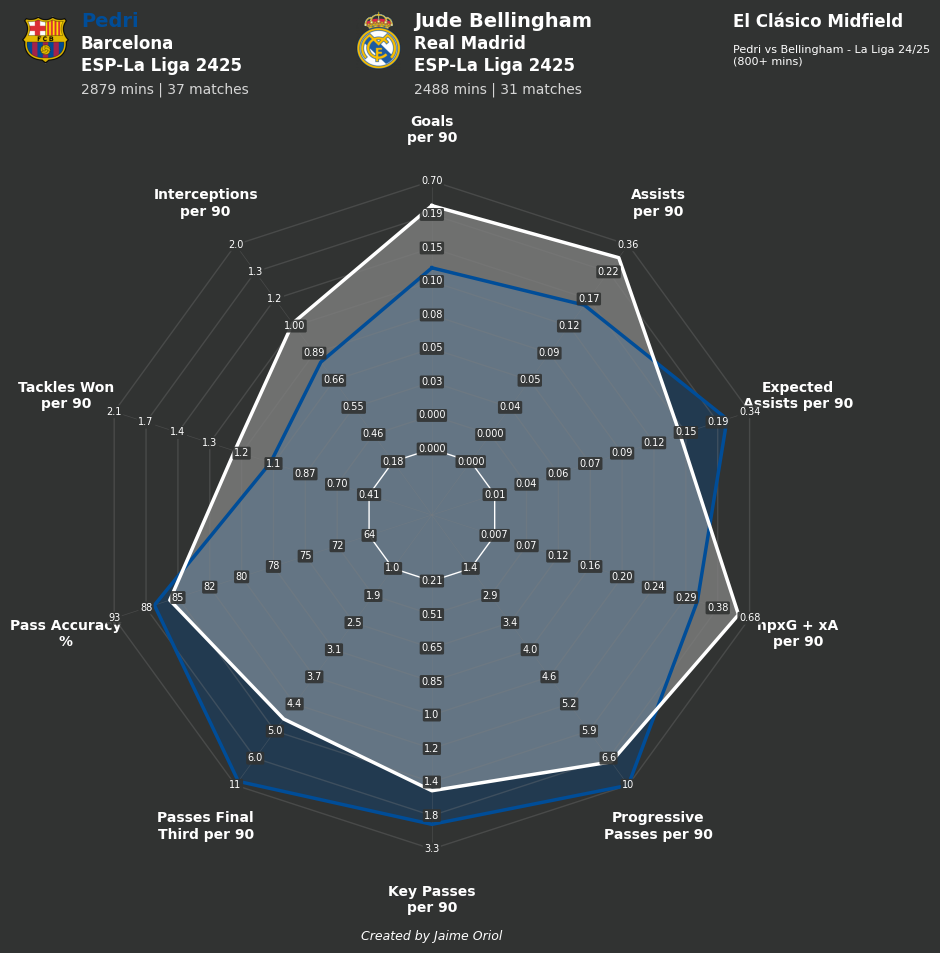

Gráficos generados en: images/pedri_bellingham_laliga


In [15]:
from viz.swarm_radar import create_player_radar

if len(radar_metrics) == 10 and PLAYER_1_ID:
    
    # Gráfico 1: Swarm Radar (comparación)
    if PLAYER_2_ID:
        create_player_radar(
            df_data=df_final,
            player_1_id=PLAYER_1_ID,
            player_2_id=PLAYER_2_ID,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            radar_title=RADAR_TITLE,
            radar_description=RADAR_DESCRIPTION,
            save_path=f"{SAVE_PATH_BASE}_swarm.png",
            team_colors=TEAM_COLORS,
            team_logos=team_logos,
            use_swarm=True
        )
    
    # Gráfico 2: Radar individual (jugador 1)
    create_player_radar(
        df_data=df_final,
        player_1_id=PLAYER_1_ID,
        metrics=radar_metrics,
        metric_titles=radar_titles,
        radar_title=f"{RADAR_TITLE} - Individual",
        radar_description=RADAR_DESCRIPTION,
        save_path=f"{SAVE_PATH_BASE}_individual.png",
        team_colors=TEAM_COLORS,
        team_logos=team_logos,
        use_swarm=False
    )
    
    # Gráfico 3: Radar tradicional (comparación)
    if PLAYER_2_ID:
        create_player_radar(
            df_data=df_final,
            player_1_id=PLAYER_1_ID,
            player_2_id=PLAYER_2_ID,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            radar_title=RADAR_TITLE,
            radar_description=RADAR_DESCRIPTION,
            save_path=f"{SAVE_PATH_BASE}_traditional.png",
            team_colors=TEAM_COLORS,
            team_logos=team_logos,
            use_swarm=False
        )
    
    print(f"Gráficos generados en: {SAVE_PATH_BASE}")
else:
    print("No se pueden generar gráficos: verificar métricas y IDs de jugadores")

In [16]:
# VERIFICAR DATOS DE LOS JUGADORES SELECCIONADOS
if PLAYER_1_ID:
    player_ids = [PLAYER_1_ID]
    if PLAYER_2_ID:
        player_ids.append(PLAYER_2_ID)
    
    # Métricas base sin sufijos
    base_metrics = [m.replace('_per90', '').replace('_pct', '') for m in radar_metrics]
    
    # Columnas a mostrar
    cols_to_show = ['player_name', 'team', 'minutes_played', 'matches_played'] + base_metrics + [f'{m}_pct' for m in base_metrics]
    cols_to_show = [col for col in cols_to_show if col in df_final.columns]
    
    # Filtrar y mostrar
    players_data = df_final[df_final['unique_player_id'].isin(player_ids)][cols_to_show]
    
    print("DATOS DE LOS JUGADORES:")
    print("="*50)
    for idx, row in players_data.iterrows():
        print(f"\n{row['player_name']} - {row['team']}")
        print(f"Minutos: {row['minutes_played']}, Partidos: {row['matches_played']}")
        print("-"*30)
        for metric in base_metrics:
            if metric in row.index:
                val = row[metric]
                pct_col = f'{metric}_pct'
                pct = row[pct_col] if pct_col in row.index else 'N/A'
                print(f"{metric:<30} {val:>10.2f} (P{pct})")

DATOS DE LOS JUGADORES:

Pedri - Barcelona
Minutos: 2879.0, Partidos: 37.0
------------------------------
goals                                4.00 (P83)
assists                              5.00 (P89)
expected_assists                     7.40 (P97)
understat_npxg_plus_xa              10.32 (P97)
progressive_passes                 360.00 (P99)
key_passes                          70.00 (P98)
passes_final_third                 331.00 (P99)
tackles_won                         34.00 (P81)
interceptions                       26.00 (P79)

Jude Bellingham - Real Madrid
Minutos: 2488.0, Partidos: 31.0
------------------------------
goals                                9.00 (P96)
assists                              8.00 (P98)
expected_assists                     3.90 (P86)
understat_npxg_plus_xa              15.90 (P99)
progressive_passes                 199.00 (P95)
key_passes                          42.00 (P89)
passes_final_third                 130.00 (P84)
tackles_won                     